# MLP Validation

In [ ]:
import numpy as np
import joblib
import itertools
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score

# === Load Data ===
X_train_input = joblib.load("Data/Xtrain1.pkl")
Y_train_input = np.load("Data/Ytrain1.npy")

# Extract patient IDs
patient_ids = X_train_input["Patient_Id"].values
unique_patients = np.unique(patient_ids)
print(f"Unique patients: {unique_patients}")

# === Best MLP hyperparameters ===
best_params = {
    'activation': 'relu', 
    'alpha': 1e-05, 
    'hidden_layer_sizes': (256, 128), 
    'learning_rate_init': 0.001
    }

# === Load best features ===
best_features = np.load("Validation/best_features_mlp.npy")
print(f"Using {len(best_features)} best features.")

# === Prepare all 3-patient test combinations ===
patient_combos = list(itertools.combinations(unique_patients, 3))
results = []

pbar = tqdm(patient_combos, desc="Testing patient combinations")

for test_patients in pbar:
    # Split data into train/test
    mask_test = np.isin(patient_ids, test_patients)
    mask_train = ~mask_test

    X_train_df = X_train_input[mask_train]
    Y_train = Y_train_input[mask_train]
    X_test_df = X_train_input[mask_test]
    Y_test = Y_train_input[mask_test]

    # Extract feature arrays
    X_train = np.vstack(X_train_df["Skeleton_Features"].values)
    X_test = np.vstack(X_test_df["Skeleton_Features"].values)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Select best features
    X_train_best = X_train_scaled[:, best_features]
    X_test_best = X_test_scaled[:, best_features]

    # Define and train model
    model = MLPClassifier(max_iter=600, random_state=42, **best_params)
    model.fit(X_train_best, Y_train)

    # Predict and compute metrics
    Y_pred = model.predict(X_test_best)
    f1 = f1_score(Y_test, Y_pred, average="macro")

    # Store results
    results.append({
        "test_patients": test_patients,
        "f1_macro": f1
    })

    # Update progress bar
    pbar.set_postfix({"F1_macro": f"{f1:.4f}"})

pbar.close()

# === Analyze results ===
f1_scores = [r["f1_macro"] for r in results]
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

print(f"\) across all 3-patient test combinations: {mean_f1:.4f} ± {std_f1:.4f}")

# === Plot results ===
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(results)+1), f1_scores, marker='o')
plt.xlabel("Test combination index")
plt.ylabel("F1-score (macro)")
plt.title(f"F1 Performance per 3-Patient Test Split (MLP)")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Show top and worst performing combos ===
sorted_results = sorted(results, key=lambda x: x["f1_macro"], reverse=True)

print("\nTop 3 performing test combinations:")
for r in sorted_results[:3]:
    print(f"  Patients {r['test_patients']} -> F1 = {r['f1_macro']:.4f}")

print("\nWorst 3 performing test combinations:")
for r in sorted_results[-3:]:
    print(f"  Patients {r['test_patients']} -> F1 = {r['f1_macro']:.4f}")


<>:85: SyntaxWarning: invalid escape sequence '\)'
<>:85: SyntaxWarning: invalid escape sequence '\)'
/tmp/ipykernel_44475/3277834891.py:85: SyntaxWarning: invalid escape sequence '\)'
  print(f"\) across all 3-patient test combinations: {mean_f1:.4f} ± {std_f1:.4f}")


Unique patients: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Using 122 best features.


Testing patient combinations:   0%|          | 0/364 [00:00<?, ?it/s]

Testing patient combinations:  50%|█████     | 183/364 [14:11<12:03,  4.00s/it, F1_macro=0.7981]/home/davidmarafuzgaspar/.pyenv/versions/3.13.7/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:788: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
Testing patient combinations:  51%|█████▏    | 187/364 [14:25<10:41,  3.62s/it, F1_macro=0.7577]

# SVM Validation

Unique patients: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Using 93 best features.


Testing patient combinations: 100%|██████████| 364/364 [00:10<00:00, 35.08it/s, F1_macro=0.8086]



Average F1 (macro) across all 3-patient test combinations: 0.8567 ± 0.0872


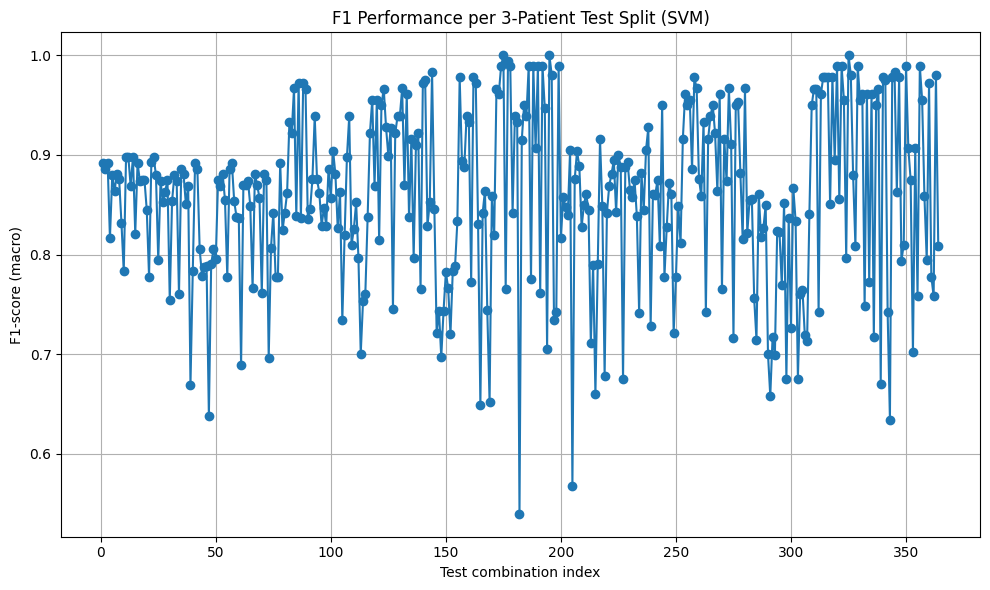


Top 3 performing test combinations:
  Patients (np.int64(3), np.int64(7), np.int64(11)) -> F1 = 1.0000
  Patients (np.int64(3), np.int64(11), np.int64(13)) -> F1 = 1.0000
  Patients (np.int64(7), np.int64(11), np.int64(13)) -> F1 = 1.0000

Worst 3 performing test combinations:
  Patients (np.int64(8), np.int64(12), np.int64(14)) -> F1 = 0.6342
  Patients (np.int64(4), np.int64(5), np.int64(11)) -> F1 = 0.5677
  Patients (np.int64(3), np.int64(8), np.int64(12)) -> F1 = 0.5398


In [3]:
import numpy as np
import joblib
import itertools
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score

# === Load Data ===
X_train_input = joblib.load("Data/Xtrain1.pkl")
Y_train_input = np.load("Data/Ytrain1.npy")

# Extract patient IDs
patient_ids = X_train_input["Patient_Id"].values
unique_patients = np.unique(patient_ids)
print(f"Unique patients: {unique_patients}")

# === Best SVM hyperparameters (Inital) ===
best_params = {
    'C': 1, 
    'gamma': 'auto',
    'kernel': 'rbf'
    }


# === Best SVM hyperparameters (After CV/Removal) ===
best_params = {
    'C': 1, 
   'gamma': 'scale',
    'kernel': 'linear'
    }
    
# It was worse on average

# === Load best features ===
best_features = np.load("Validation/best_features_svm.npy")
print(f"Using {len(best_features)} best features.")

# === Prepare all 3-patient test combinations ===
patient_combos = list(itertools.combinations(unique_patients, 3))
results = []

pbar = tqdm(patient_combos, desc="Testing patient combinations")

for test_patients in pbar:
    # Split data into train/test
    mask_test = np.isin(patient_ids, test_patients)
    mask_train = ~mask_test

    X_train_df = X_train_input[mask_train]
    Y_train = Y_train_input[mask_train]
    X_test_df = X_train_input[mask_test]
    Y_test = Y_train_input[mask_test]

    # Extract feature arrays
    X_train = np.vstack(X_train_df["Skeleton_Features"].values)
    X_test = np.vstack(X_test_df["Skeleton_Features"].values)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Select best features
    X_train_best = X_train_scaled[:, best_features]
    X_test_best = X_test_scaled[:, best_features]

    # Define and train SVM model
    model = SVC(probability=True, random_state=42, **best_params)
    model.fit(X_train_best, Y_train)

    # Predict and compute F1-score
    Y_pred = model.predict(X_test_best)
    f1 = f1_score(Y_test, Y_pred, average="macro")

    # Store results
    results.append({
        "test_patients": test_patients,
        "f1_macro": f1
    })

    # Update progress bar
    pbar.set_postfix({"F1_macro": f"{f1:.4f}"})

pbar.close()

# === Analyze results ===
f1_scores = [r["f1_macro"] for r in results]
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

print(f"\nAverage F1 (macro) across all 3-patient test combinations: {mean_f1:.4f} ± {std_f1:.4f}")

# === Plot results ===
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(results)+1), f1_scores, marker='o')
plt.xlabel("Test combination index")
plt.ylabel("F1-score (macro)")
plt.title(f"F1 Performance per 3-Patient Test Split (SVM)")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Show top and worst performing combos ===
sorted_results = sorted(results, key=lambda x: x["f1_macro"], reverse=True)

print("\nTop 3 performing test combinations:")
for r in sorted_results[:3]:
    print(f"  Patients {r['test_patients']} -> F1 = {r['f1_macro']:.4f}")

print("\nWorst 3 performing test combinations:")
for r in sorted_results[-3:]:
    print(f"  Patients {r['test_patients']} -> F1 = {r['f1_macro']:.4f}")
